In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
df_original = pd.read_csv("datasets/historical_demand.csv")
df_original.head()

,anio,mes,agente_nemo,agente_descripcion,tipo_agente,region,provincia,categoria_area,categoria_demanda,tarifa,categoria_tarifa,demanda_MWh,indice_tiempo
0,2012,1,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,2222.628,2012-01
1,2012,1,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,536.858,2012-01
2,2012,1,ACARSLSY,ASOC.COOP.ARG. - San Lorenzo,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,336.297,2012-01
3,2012,1,ACINROSY,ACINDAR ROSARIO EX-NAVARRO,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,601.066,2012-01
4,2012,1,ACINTBOY,ACINDAR PTA. TABLADA,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,3076.618,2012-01


In [51]:
df_time_series = df_original[['indice_tiempo', 'demanda_MWh']].groupby('indice_tiempo').sum()
pd.to_datetime(df_time_series.index)


DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
      

In [71]:
df_time_series.index.names = ['time_index']

In [72]:
df_time_series.rename(columns={'demanda_MWh': 'demand_MWh'}, inplace=True)

In [73]:
df_time_series.describe()

,demand_MWh
count,9.800000e+01
mean,1.175291e+07
std,1.336332e+06
min,8.969068e+06
25%,1.058506e+07
50%,1.186014e+07
75%,1.268995e+07
max,1.493529e+07


## CHECK GAPS BETWEEN DATES

In [74]:
df_time_series_check_gaps = df_time_series.reset_index()
df_time_series_check_gaps['gap'] = pd.to_datetime(df_time_series_check_gaps['time_index']).sort_values().diff() > pd.to_timedelta('31 days')
df_time_series_check_gaps[df_time_series_check_gaps['gap']]

,time_index,demand_MWh,gap


<AxesSubplot: xlabel='indice_tiempo'>

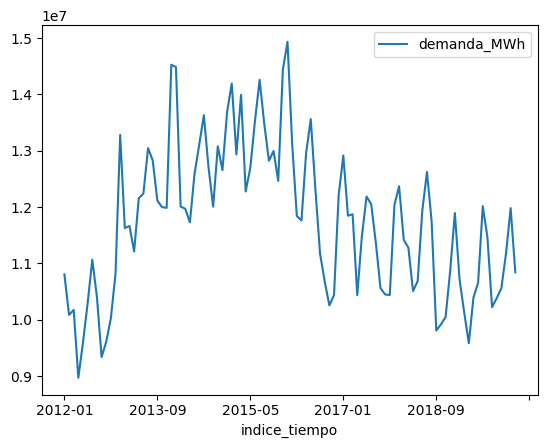

In [58]:
df_time_series.plot()

In [75]:
df_time_series.to_csv('datasets/historical_demand_sum.csv')